# Import Necessary Packages and Libraries

In [1]:
# IMAGE PREPROCESSING FUNCTIONS FOR USE IN MODEL DEVELOPMENT, EVALUATION, AND PRODUCTION
import numpy as np
import pandas as pd
import PIL as pil
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import tempfile
import pickle
import time
import gc
import skimage.filters
import cv2
import watermark
import joblib
import math
import sys
from skimage.measure import block_reduce
from image_preprocessing import standardize_image_dataset,resize_dataset,binarize_dataset,crop_dataset,process_dataset_blur,do_pooling_dataset
from eval_on_test import make_preds

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB,CategoricalNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.base import clone
from sklearn.metrics import confusion_matrix

C:\Users\AGatt\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Read in Test Data

In [2]:
test_data = pickle.load(open('Amit/Labeled Data/test_data.pkl','rb'))
y = test_data['label']
x = test_data.iloc[:,:-1]

# Evaluate Optimal Gradient Boosted Classification Tree (w/ optimal associated preprocessing steps) on Test Data

In [3]:
model_dict = pickle.load(open('Partition Based Model Results/gbct1.pkl','rb'))
print(model_dict['best_model'])
print(model_dict['best_score'])
print(model_dict['best_thresh'])
print(model_dict['best_preprocess'])

GradientBoostingClassifier(max_depth=4, max_features='sqrt', n_estimators=500,
                           random_state=50)
0.9703247480403135
0.51
(Initial Standardization/Resizing to (16, 16))


### Preprocess and make predictions on test data and evaluate performance

In [4]:
timer = time.time()
preds = make_preds(x,y,[('resize',[(256,256),(32,32)]),
               ('resize',[(32,32),(16,16)])],
          model_dict['best_model'],model_dict['best_thresh'])
print('Time to make ' + str(len(x)) + ' predictions: ' + str(time.time()-timer) + ' seconds')
print('Model Size: ' + str(sys.getsizeof(pickle.dumps(model_dict['best_model']))) + ' Bytes')
print(preds)

Time to make 1380 predictions: 49.88211750984192 seconds
Model Size: 1041676 Bytes
{'features':       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
3949       0       0       0       0       0       0       0       0       0   
230       12     110      75      71      75     123     178     209     204   
354        0       0       0       0       0      16      29      57      60   
2736       0       0       0       0       0       0       0       0       0   
3540       0       0       0       0       0      37      94     120     101   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1776       0       6      10       2       0       0      14      30      32   
1791       0       1       2       1       1       0       0      10      11   
2099       0       0       1       1       1       2       2       1       2   
53         1       1       1       1       0       2      13      23      24   
3857       2       1    

### See where model misclassified images, gather original + preprocessed image, the label, and the predicted probability of a cancerous image

In [5]:
misclassified_images = x[preds['preds'] != y]
misclassified_preprocessed_images = preds['features'][preds['preds'] != y]
misclassified_labels = y[preds['preds'] != y]
misclassified_probabilities = preds['probs'][preds['preds'] != y]

### Print out misclassified images, show actual/predicted value and predicted likelihood of predicted label

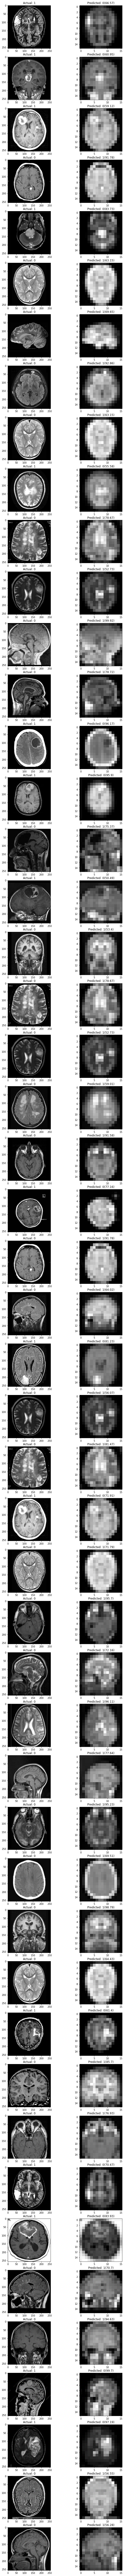

In [6]:
fig,axes = plt.subplots(nrows=len(misclassified_images),ncols=2,figsize=(10,int(len(misclassified_images)*4)))
for num in range(len(misclassified_images)):
    axes[num][0].imshow(np.array(misclassified_images.iloc[num]).reshape(256,256),cmap='gray')
    axes[num][1].imshow(np.array(misclassified_preprocessed_images.iloc[num]).reshape(int(np.sqrt(misclassified_preprocessed_images.shape[1])),
                                                                                      int(np.sqrt(misclassified_preprocessed_images.shape[1]))),cmap='gray')
    axes[num][0].set_title('Actual: ' + str(misclassified_labels.iloc[num]))
    if misclassified_labels.iloc[num] == 0:
        axes[num][1].set_title('Predicted: ' + str(abs(misclassified_labels.iloc[num] - 1)) + '(' + str(round(100*misclassified_probabilities[num],2)) + ')')
    else:
        axes[num][1].set_title('Predicted: ' + str(abs(misclassified_labels.iloc[num] - 1)) + '(' + str(round(100 - 100*misclassified_probabilities[num],2)) + ')')

# Evaluate Optimal Random Forest (w/ optimal associated preprocessing steps) on Test Data

In [7]:
model_dict1 = pickle.load(open('Partition Based Model Results/rf2.pkl','rb'))
print(model_dict1['best_model'])
print(model_dict1['best_score'])
print(model_dict1['best_thresh'])
print(model_dict1['best_preprocess'])

RandomForestClassifier(min_samples_leaf=3, n_estimators=500, random_state=50)
0.9614843969637336
0.56
(Initial Standardization/Resizing to (32, 32))(Blurring, Type = g, Dimension = (32, 32), Kernel = (3, 3), sigma_x = 2, sigma_y = 2)


### Preprocess and make predictions on test data and evaluate performance

In [8]:
timer = time.time()
preds1 = make_preds(x,y,[('resize',[(256,256),(32,32)]),
               ('resize',[(32,32),(32,32)]),
               ('blur',['g',(32,32),(3,3),2,2])],
          model_dict1['best_model'],model_dict1['best_thresh'])
print('Time to make ' + str(len(x)) + ' predictions: ' + str(time.time()-timer) + ' seconds')
print('Model Size: ' + str(sys.getsizeof(pickle.dumps(model_dict1['best_model']))) + ' Bytes')
print(preds1)

Time to make 1380 predictions: 49.76129508018494 seconds
Model Size: 11072962 Bytes
{'features':         pixel0     pixel1     pixel2     pixel3     pixel4     pixel5  \
3949  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
230   0.000000  44.099403  80.304260  95.731789  68.517250  56.991379   
354   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2736  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3540  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
...        ...        ...        ...        ...        ...        ...   
1776  1.453280   1.434599   3.361364   8.488853   8.986135   7.096149   
1791  0.000000   0.319168   1.088305   1.869199   2.276671   1.869199   
2099  0.000000   0.000000   0.000000   0.000000   0.203736   0.434599   
53    0.638336   0.680832   1.000000   1.000000   1.000000   1.000000   
3857  2.045808   1.942134   1.726640   1.434599   1.203736   1.203736   

         pixel6     pixel7

### See where model misclassified images, gather original + preprocessed image, the label, and the predicted probability of a cancerous image

In [9]:
misclassified_images1 = x[preds1['preds'] != y]
misclassified_preprocessed_images1 = preds1['features'][preds1['preds'] != y]
misclassified_labels1 = y[preds1['preds'] != y]
misclassified_probabilities1 = preds1['probs'][preds1['preds'] != y]

### Print out misclassified images, show actual/predicted value and predicted likelihood of predicted label

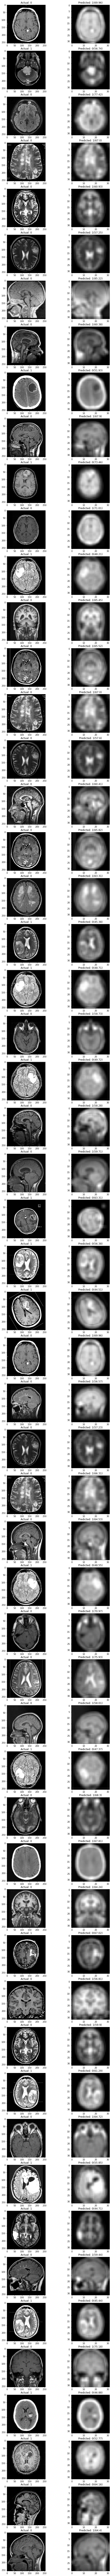

In [10]:
fig,axes = plt.subplots(nrows=len(misclassified_images1),ncols=2,figsize=(10,int(len(misclassified_images1)*4)))
for num in range(len(misclassified_images1)):
    axes[num][0].imshow(np.array(misclassified_images1.iloc[num]).reshape(256,256),cmap='gray')
    axes[num][1].imshow(np.array(misclassified_preprocessed_images1.iloc[num]).reshape(int(np.sqrt(misclassified_preprocessed_images1.shape[1])),
                                                                                      int(np.sqrt(misclassified_preprocessed_images1.shape[1]))),cmap='gray')
    axes[num][0].set_title('Actual: ' + str(misclassified_labels1.iloc[num]))
    if misclassified_labels1.iloc[num] == 0:
        axes[num][1].set_title('Predicted: ' + str(abs(misclassified_labels1.iloc[num] - 1)) + '(' + str(round(100*misclassified_probabilities1[num],2)) + ')')
    else:
        axes[num][1].set_title('Predicted: ' + str(abs(misclassified_labels1.iloc[num] - 1)) + '(' + str(round(100 - 100*misclassified_probabilities1[num],2)) + ')')

In [11]:
misclassified_ids = list(misclassified_preprocessed_images.index)
misclassified_ids.extend(misclassified_preprocessed_images1.index)

In [12]:
print(len(set(misclassified_ids)))
print(len(misclassified_ids))

73
106
